# System tools to herd the dumps into something useful

In [1]:
%pylab nbagg

import os
import re

from topas2numpy import read_ntuple
from datetime import datetime
from pylab import figure, cm
from matplotlib.colors import LogNorm

Populating the interactive namespace from numpy and matplotlib


## Making a new analysis directory

In [2]:
now = datetime.now()

dt_string = now.strftime("%Y-%m-%d-h%Hm%M")

print(dt_string)

os.mkdir(f'analysis/{dt_string}')

2020-10-17-h21m44


## Reformat the dump

In [28]:
!rename -e 's/\d+/sprintf("%04d",$&)/e' -- *.phsp
!rename -e 's/\d+/sprintf("%04d",$&)/e' -- *.header

Readout_flood-100keV.phsp not renamed: Readout_flood-0100keV.phsp already exists
Readout_flood-300keV.phsp not renamed: Readout_flood-0300keV.phsp already exists
Readout_flood-30keV.phsp not renamed: Readout_flood-0030keV.phsp already exists
Readout_flood-40keV.phsp not renamed: Readout_flood-0040keV.phsp already exists
Readout_flood-500keV.phsp not renamed: Readout_flood-0500keV.phsp already exists
Readout_flood-50keV.phsp not renamed: Readout_flood-0050keV.phsp already exists
Readout_flood-60keV.phsp not renamed: Readout_flood-0060keV.phsp already exists
Readout_flood-700keV.phsp not renamed: Readout_flood-0700keV.phsp already exists
Readout_flood-70keV.phsp not renamed: Readout_flood-0070keV.phsp already exists
Readout_flood-80keV.phsp not renamed: Readout_flood-0080keV.phsp already exists
Readout_flood-900keV.phsp not renamed: Readout_flood-0900keV.phsp already exists
Readout_flood-90keV.phsp not renamed: Readout_flood-0090keV.phsp already exists
Readout_flood-100keV.header not ren

In [3]:
!echo 'Messing around trying to get coherent in the mix' > ./analysis/2020-10-17-h21m44/Readme

In [10]:
#!cat energies.txt deposition.txt
#!cat deposition.txt

In [4]:
import glob

from scipy.optimize import curve_fit

dist = np.linspace(-256*0.0784 - 0.0392,256*0.0784 - 0.0392, 512)
factor = (152/(np.sqrt(dist**2 + 152**2)))**3

def func(x, a, b):

    return ((-(152/(np.sqrt(x**2 + 152**2)))**a)*b)

<IPython.core.display.Javascript object>


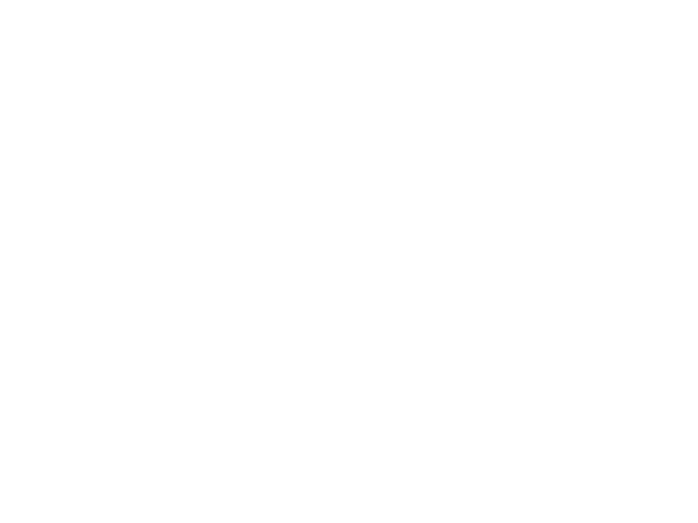

In [7]:
rootdir = "."
regex = re.compile('(.*flood*keV.phsp$)|(.*rar$)|(.*r01$)')

phase_spaces = []
plt.figure()

# xedges = np.linspace(-1.5876+0.0196,1.5876-0.0196,40) # Changed from 82 JO 2020 07
# yedges = np.linspace(-1.5876+0.0196,1.5876-0.0196,40) # Changed from 40 JO 08


edges_forward_x = (np.arange(0.0392,64*0.0782,0.0782))
edges_forward_y = (np.arange(0.0392,256*0.0782,0.0782))


# edges_forward = (np.arange(0.0196,41*0.0392,0.0392))

# edges_forward = (np.arange(0.0168,41*0.0336,0.0336))

# edges_forward = (np.arange(0.001,151*0.002,0.002))

xedges = np.hstack([-1*edges_forward_x[-1::-1], edges_forward_x])
yedges = np.hstack([-1*edges_forward_y[-1::-1], edges_forward_y])

xedges = np.linspace(-5.,5.,129,endpoint=True)
yedges = np.linspace(-20.07,20.07,513,endpoint=True)


# xedges = edges #np.linspace(-2,2,201) # Changed from 82 JO 2020 07
# yedges = edges #np.linspace(-2,2,201) # Changed from 40 JO 08

prim_slices = []
scatter_slices = []
total_slices = []

original_energies_keV = np.array([30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])

bin_edges = np.array([0,35,45,55,65,75,85,95,200,400,600,800,950,1500,3000,5000,6000])/1000

speks = []
curve_fits = np.zeros([len(original_energies_keV),len(original_energies_keV),2])
curve_covs = np.zeros([len(original_energies_keV),len(original_energies_keV),4])

path_spec = 'Readout_w6_spec_water.phsp'

scatter_on = 0

for jj, file in enumerate(sorted(glob.glob(path_spec))):


        y = read_ntuple(os.path.join(rootdir,file))
        
        y5 = y['Particle Type (in PDG Format)'] == 22
#             xx = [y[kk][0] for kk in range(y.size)]
#             yy = [y[kk][1] for kk in range(y.size)]
        h,xs,yx = np.histogram2d(y['Position X [cm]'],y['Position Y [cm]'], bins = [xedges,yedges])
#             plt.title(f'{file}')
#             plt.savefig(f'analysis/{dt_string}/{file}.png')
#             plt.axis('image')
        np.save(f'analysis/{dt_string}/{file}',h)  
    
        if scatter_on:
            e_kev = int(file[-12:-8])

            y2 = y['Energy [MeV]'] < e_kev/1000 - 0.0005
            y1 = y['Energy [MeV]'] > e_kev/1000 - 0.0005

            h_prim,xs,yx = np.histogram2d(y['Position X [cm]'][y1],y['Position Y [cm]'][y1], bins = [xedges,yedges])
        
            np.save(f'analysis/{dt_string}/{file}_prim',h_prim)
            spek, be = np.histogram(y['Energy [MeV]'][y2],bins = bin_edges)

            bin_edges_mod = bin_edges[bin_edges < e_kev/1000]
            bin_edges_mod = np.append(bin_edges_mod,e_kev/1000)

            plt.figure()
            for ii in range(len(bin_edges_mod) - 1):

                y5 = np.logical_and(y['Energy [MeV]'] > bin_edges_mod[ii],y['Energy [MeV]'] < bin_edges_mod[ii+1]+0.0005)

                h_prim2,xs = np.histogram(y['Position Y [cm]'][y5], bins = yedges)

                plt.plot(dist,h_prim2,label = f'{bin_edges_mod[ii]}-{bin_edges_mod[ii+1]} MeV')

                popt, pcov = curve_fit(func, dist, h_prim2,[3,h_prim2[256]])

                plt.plot(dist,func(dist, *popt))
                curve_fits[jj,ii,:] = popt
                curve_covs[jj,ii,:] = pcov.flatten()


            speks.append(spek)
            prim_slices.append(np.mean(h_prim,0))
            total_slices.append(np.mean(h,0))
            scatter_slices.append(np.mean(h,0)-np.mean(h_prim,0))
            

# New test of scorer from components

<IPython.core.display.Javascript object>


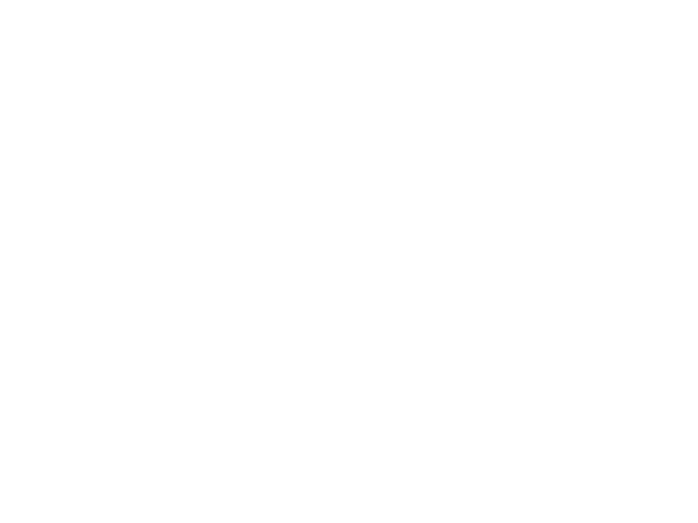

<IPython.core.display.Javascript object>


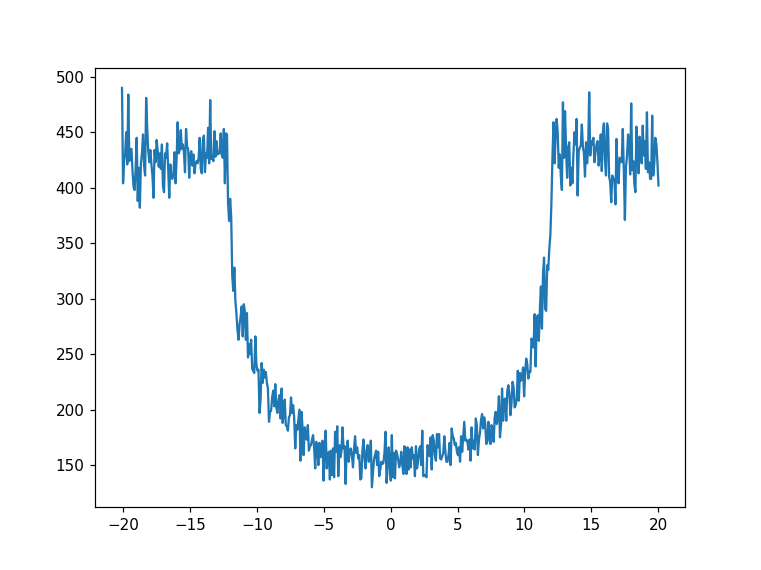

<IPython.core.display.Javascript object>


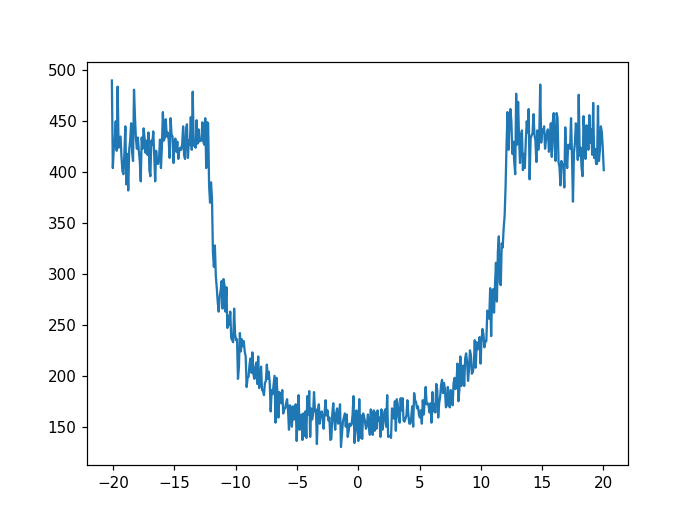

<IPython.core.display.Javascript object>


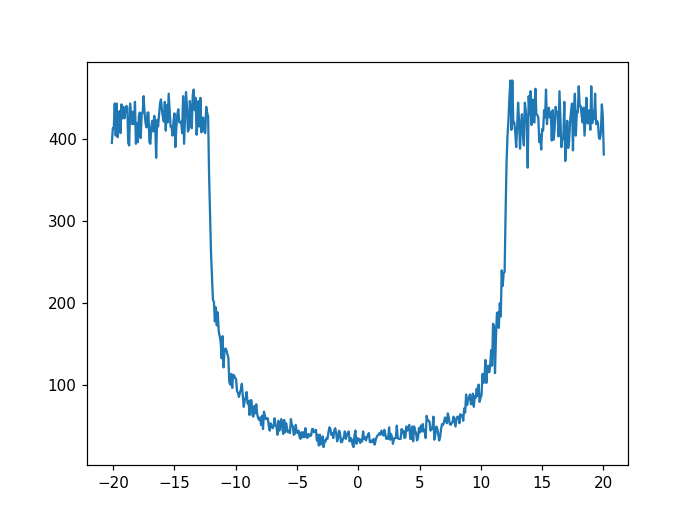

<IPython.core.display.Javascript object>


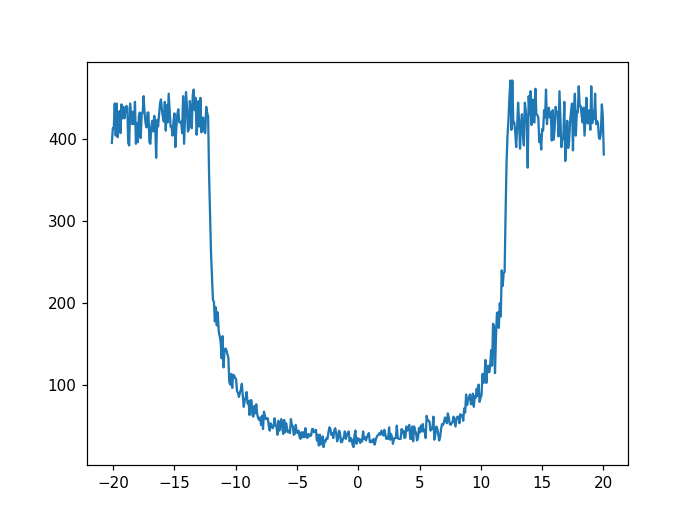

<IPython.core.display.Javascript object>


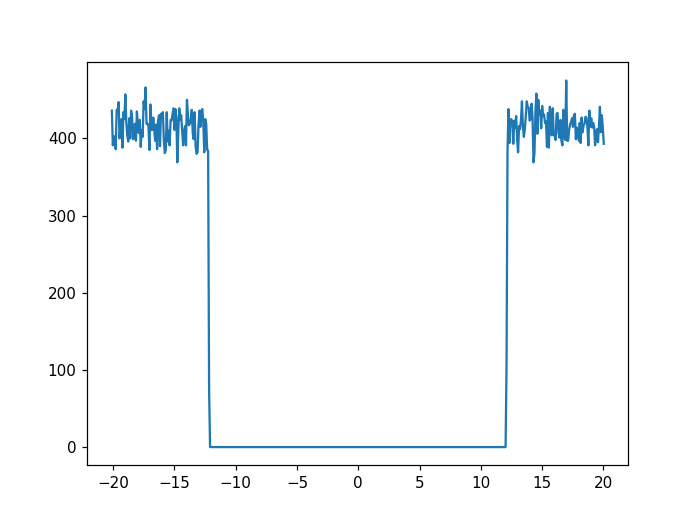

<IPython.core.display.Javascript object>


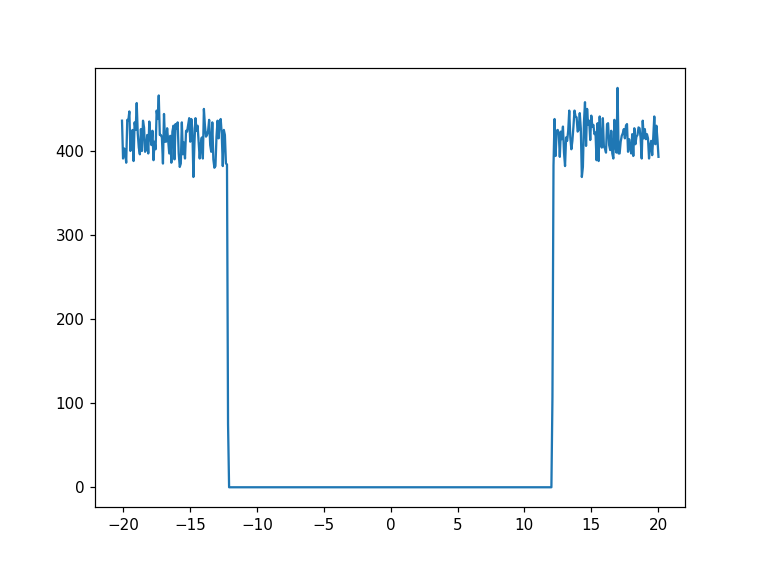

<IPython.core.display.Javascript object>


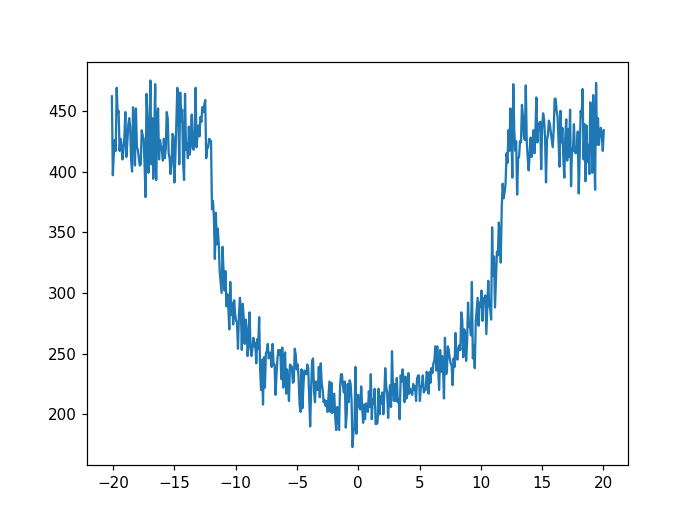

<IPython.core.display.Javascript object>


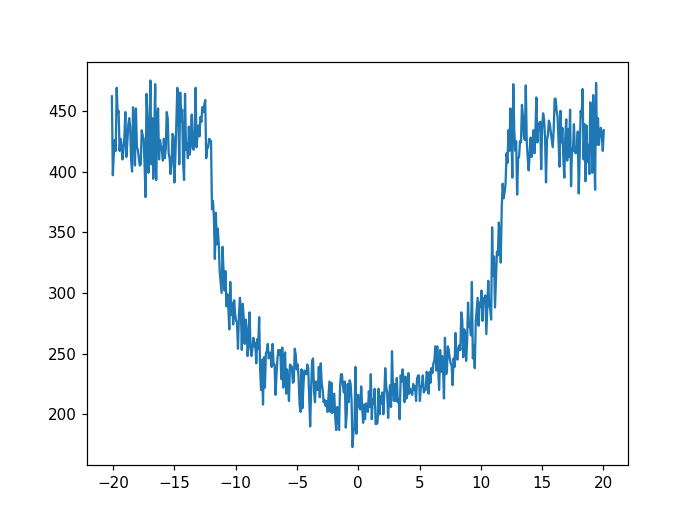

<IPython.core.display.Javascript object>


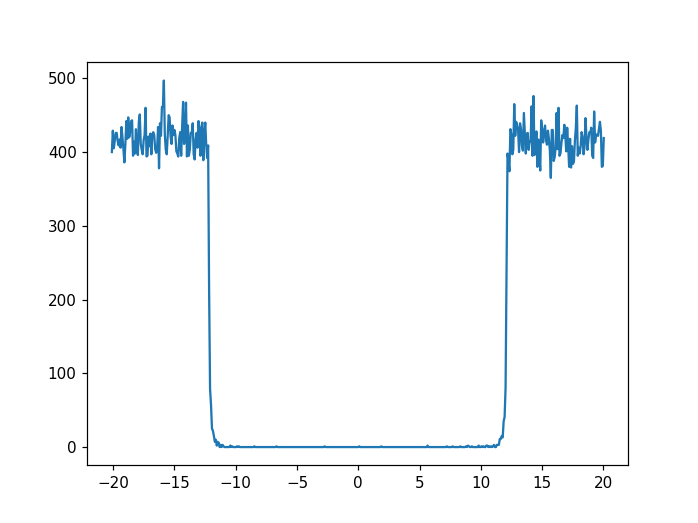

<IPython.core.display.Javascript object>


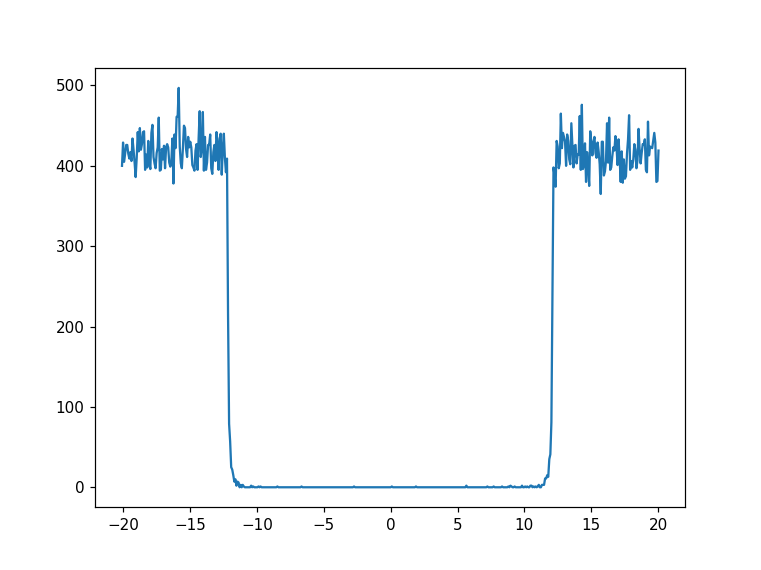

<IPython.core.display.Javascript object>


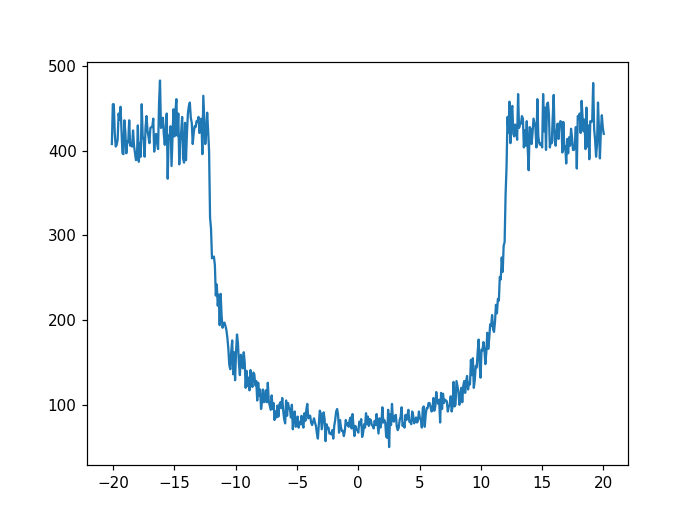

<IPython.core.display.Javascript object>


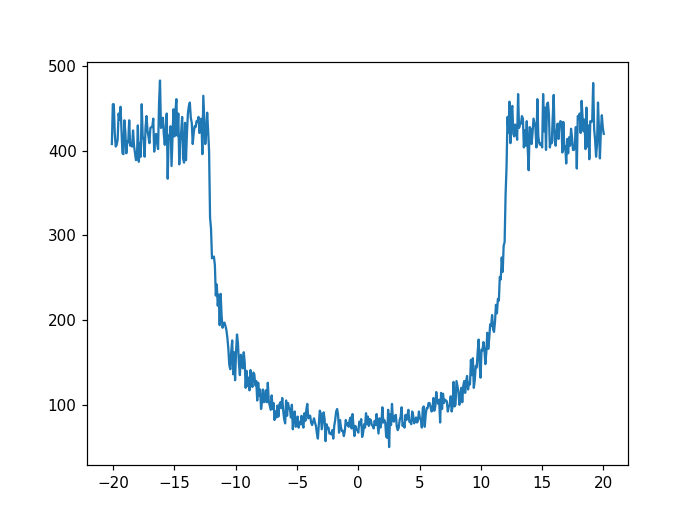

<IPython.core.display.Javascript object>


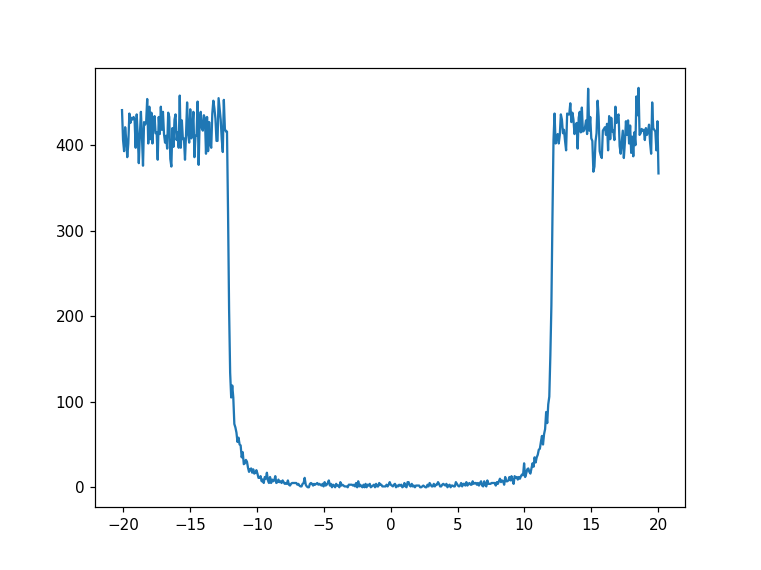

<IPython.core.display.Javascript object>


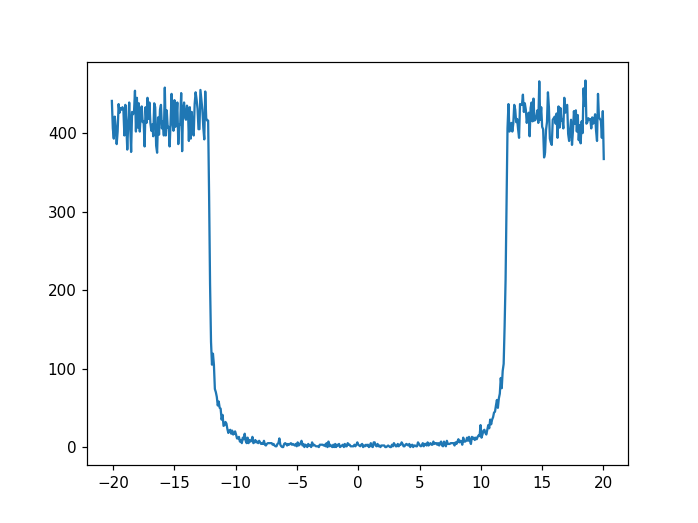

<IPython.core.display.Javascript object>


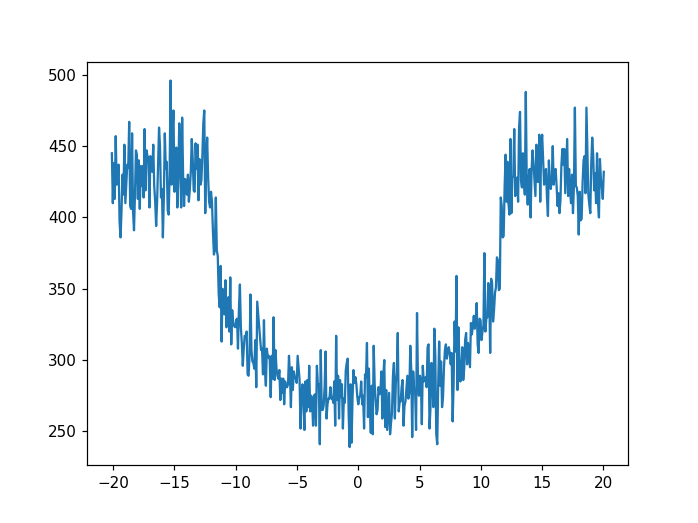

<IPython.core.display.Javascript object>


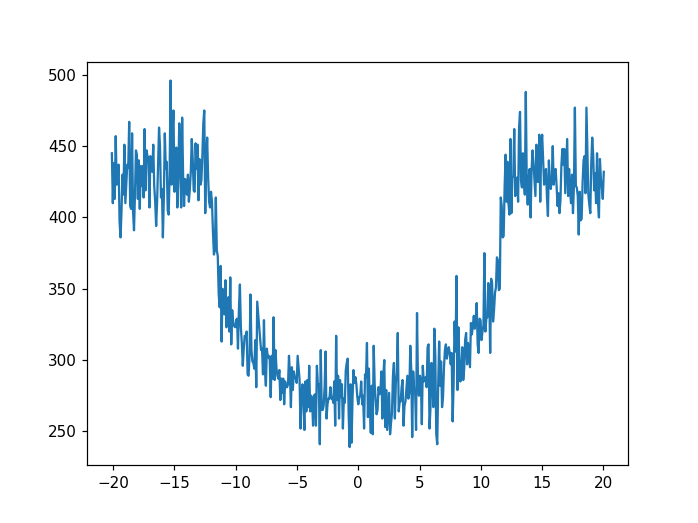

<IPython.core.display.Javascript object>


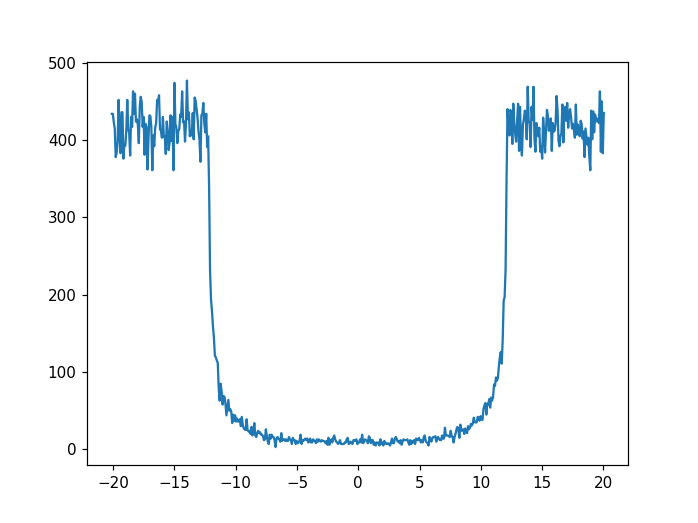

<IPython.core.display.Javascript object>


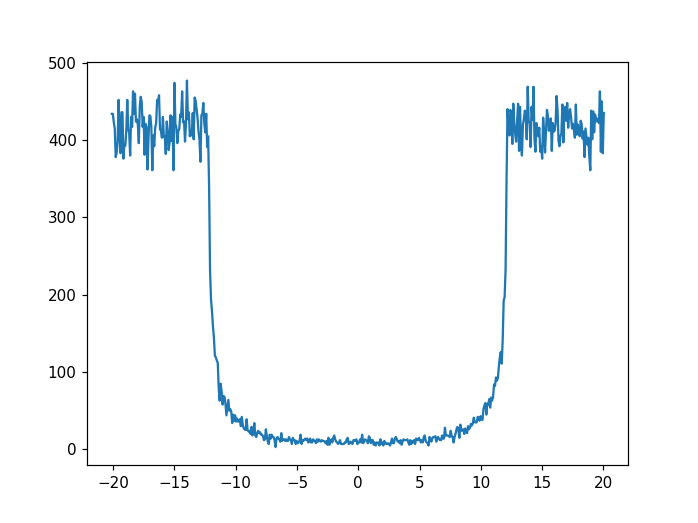

<IPython.core.display.Javascript object>


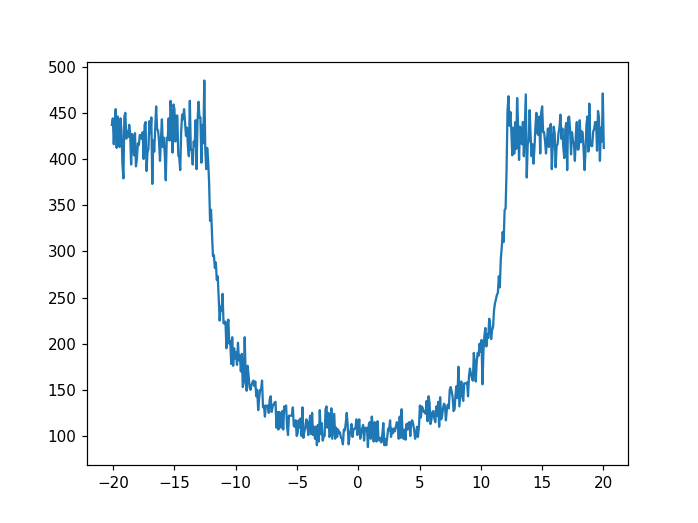

<IPython.core.display.Javascript object>


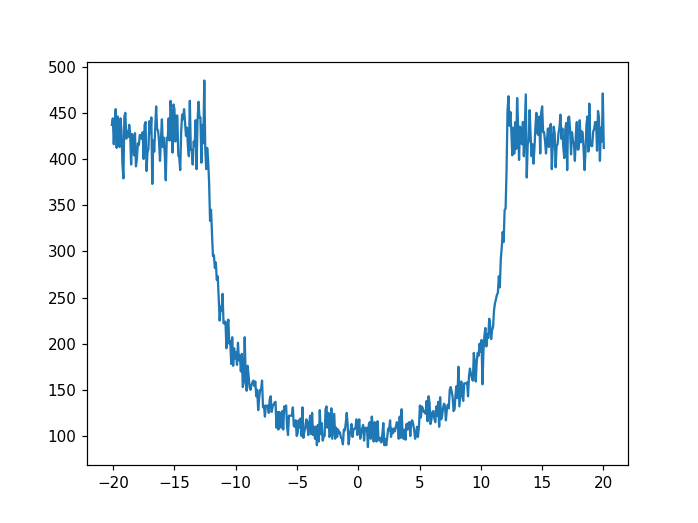

<IPython.core.display.Javascript object>


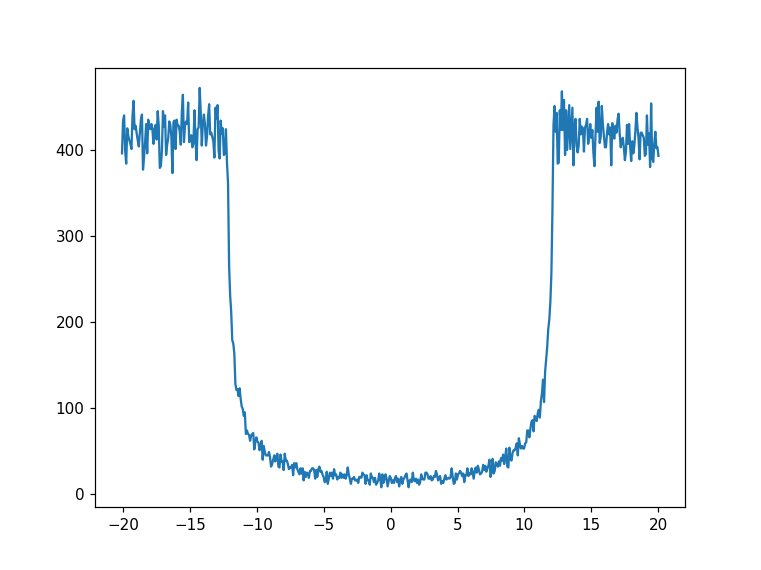

<IPython.core.display.Javascript object>


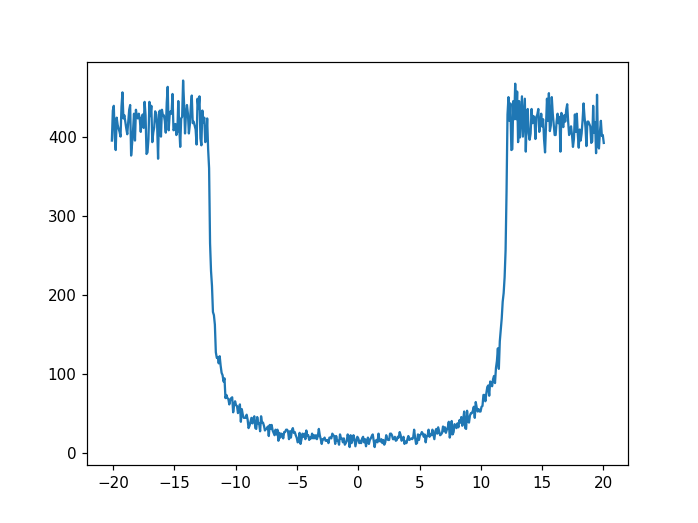

<IPython.core.display.Javascript object>


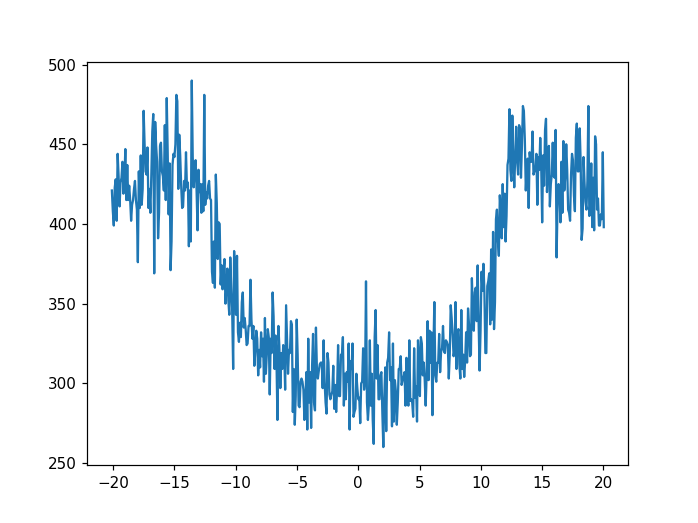

<IPython.core.display.Javascript object>


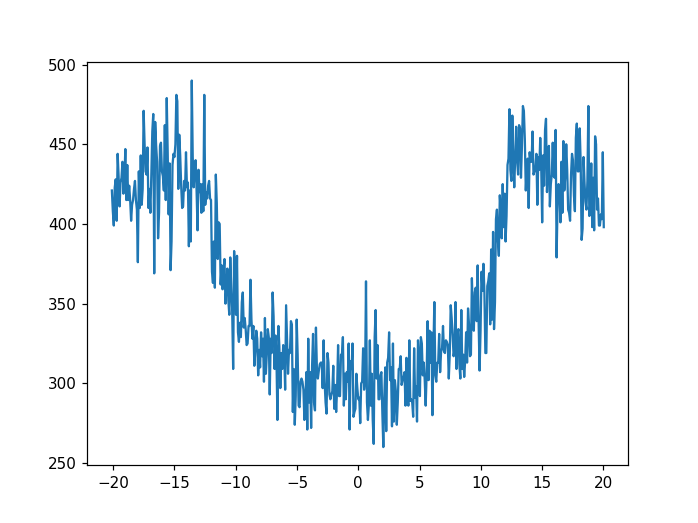

<IPython.core.display.Javascript object>


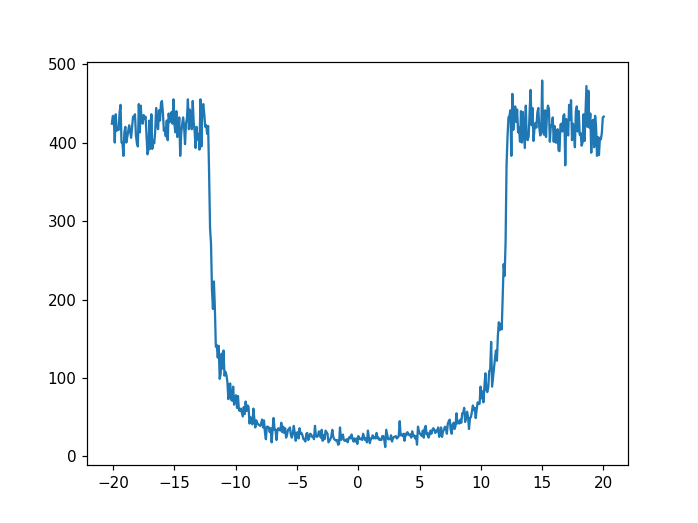

<IPython.core.display.Javascript object>


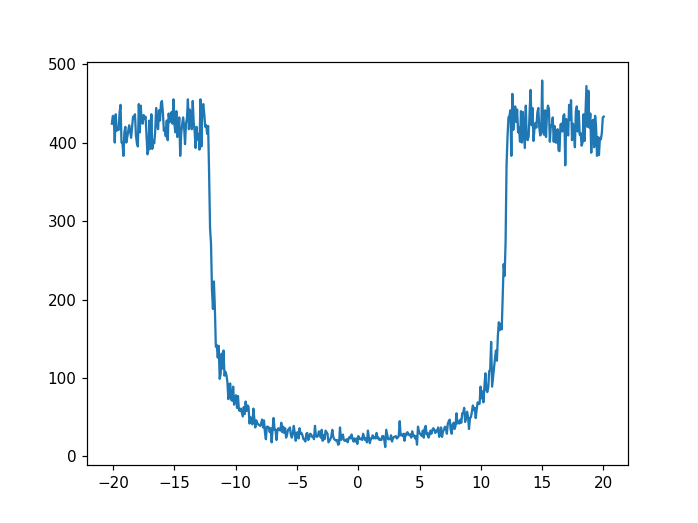

<IPython.core.display.Javascript object>


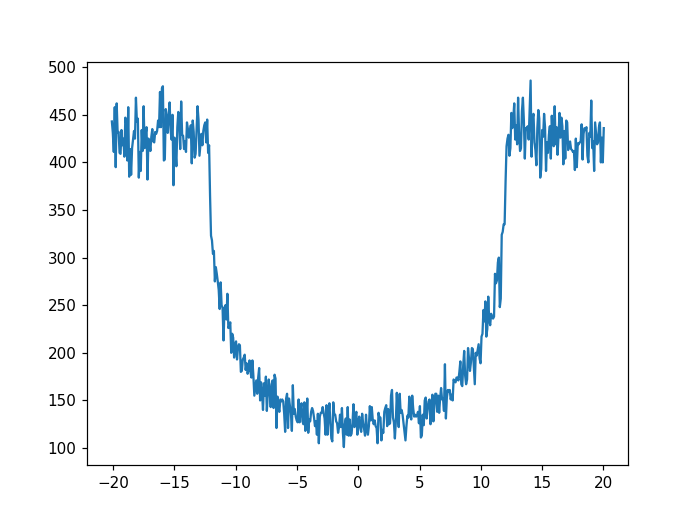

<IPython.core.display.Javascript object>


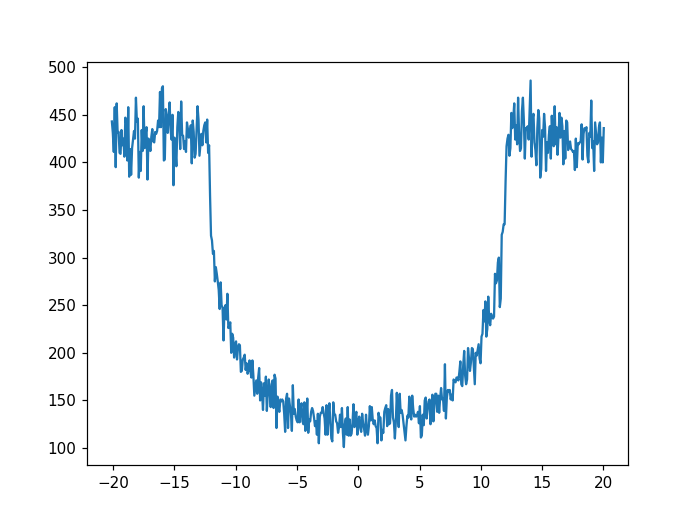

<IPython.core.display.Javascript object>


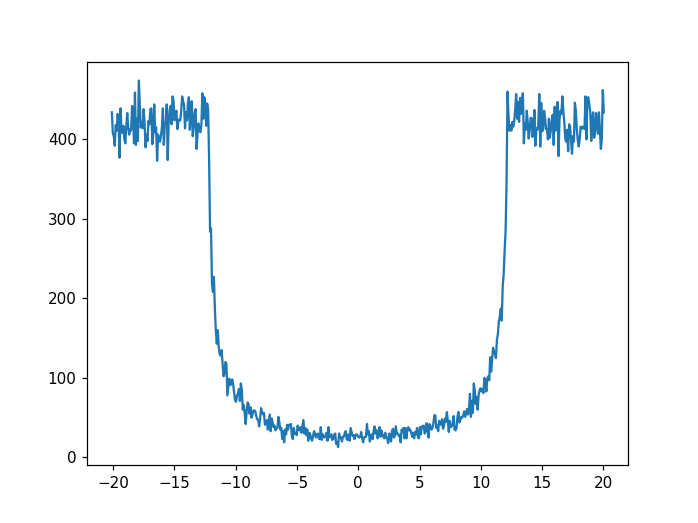

<IPython.core.display.Javascript object>


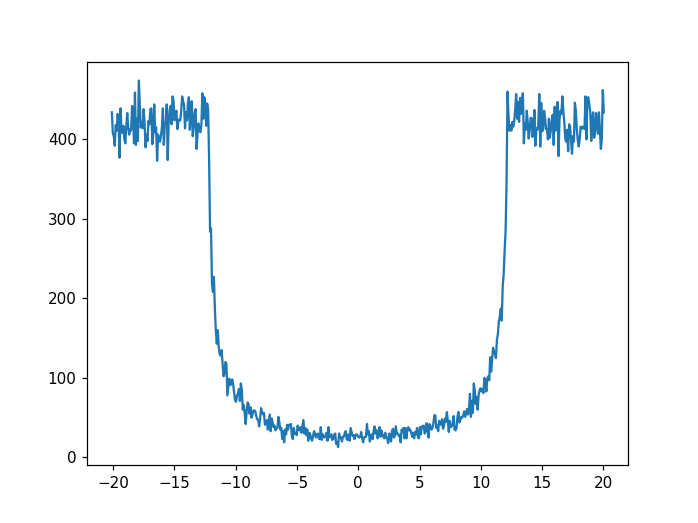

<IPython.core.display.Javascript object>


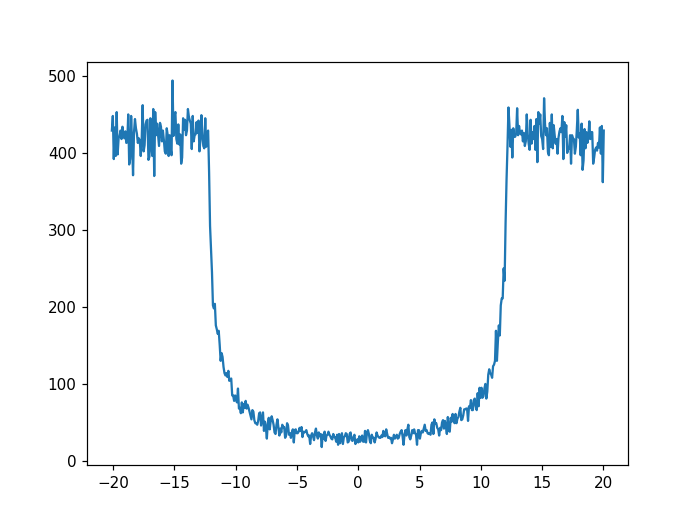

<IPython.core.display.Javascript object>


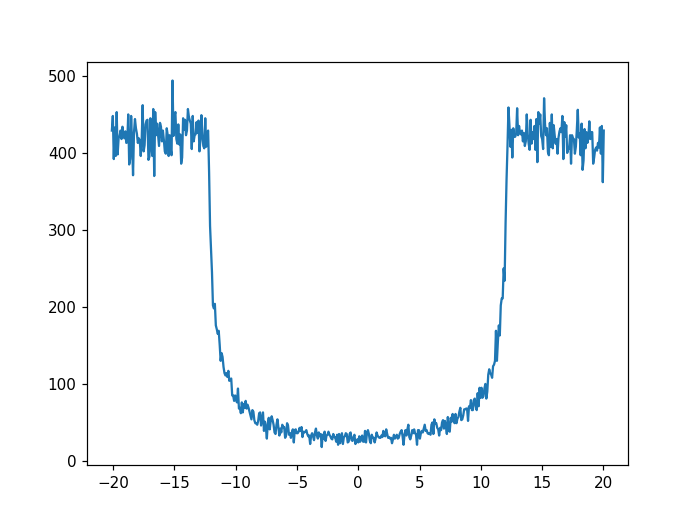

<IPython.core.display.Javascript object>


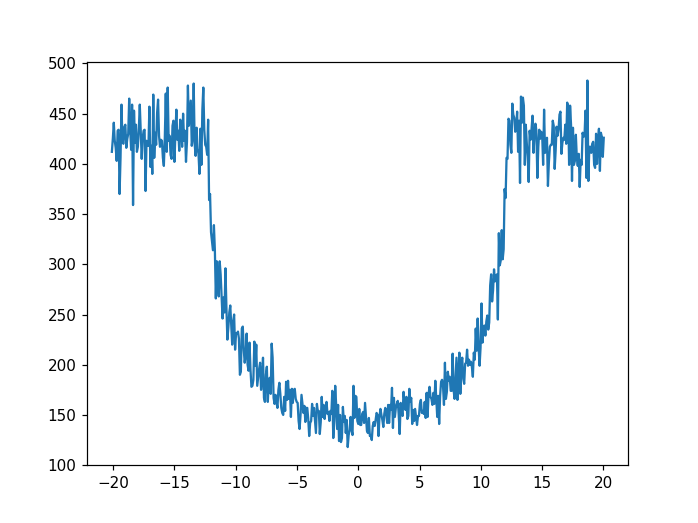

<IPython.core.display.Javascript object>


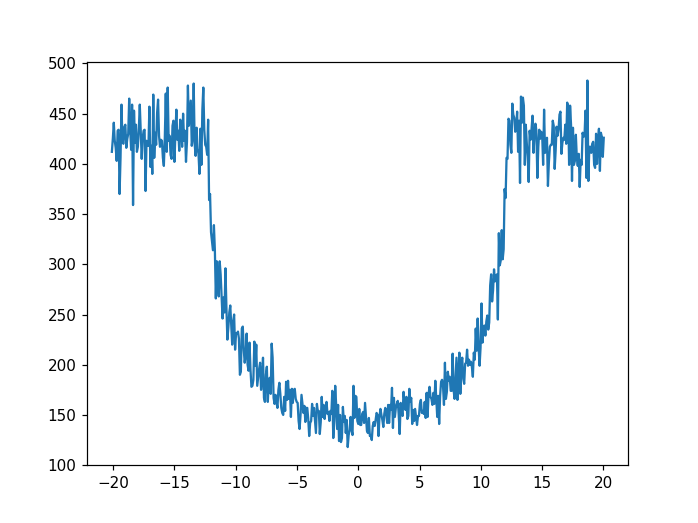

<IPython.core.display.Javascript object>


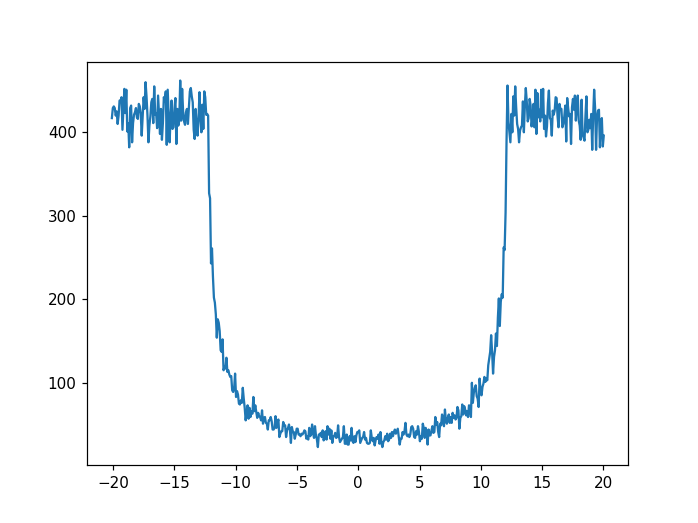

<IPython.core.display.Javascript object>


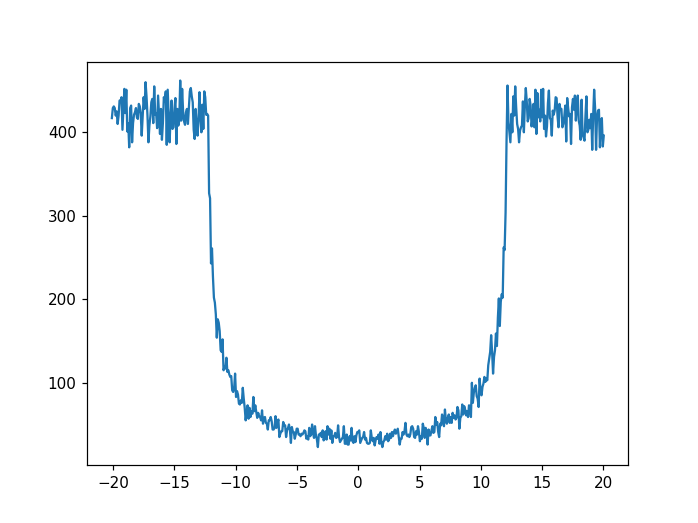

In [14]:
rootdir = "."
regex = re.compile('(.*flood*keV.phsp$)|(.*rar$)|(.*r01$)')

phase_spaces = []
plt.figure()

# xedges = np.linspace(-1.5876+0.0196,1.5876-0.0196,40) # Changed from 82 JO 2020 07
# yedges = np.linspace(-1.5876+0.0196,1.5876-0.0196,40) # Changed from 40 JO 08


edges_forward_x = (np.arange(0.0392,64*0.0782,0.0782))
edges_forward_y = (np.arange(0.0392,256*0.0782,0.0782))


# edges_forward = (np.arange(0.0196,41*0.0392,0.0392))

# edges_forward = (np.arange(0.0168,41*0.0336,0.0336))

# edges_forward = (np.arange(0.001,151*0.002,0.002))

xedges = np.hstack([-1*edges_forward_x[-1::-1], edges_forward_x])
yedges = np.hstack([-1*edges_forward_y[-1::-1], edges_forward_y])

xedges = np.linspace(-5.,5.,129,endpoint=True)
yedges = np.linspace(-20.07,20.07,513,endpoint=True)


# xedges = edges #np.linspace(-2,2,201) # Changed from 82 JO 2020 07
# yedges = edges #np.linspace(-2,2,201) # Changed from 40 JO 08

prim_slices = []
scatter_slices = []
total_slices = []

original_energies_keV = np.array([30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])

bin_edges = np.array([0,35,45,55,65,75,85,95,200,400,600,800,950,1500,3000,5000,6000])/1000

speks = []
curve_fits = np.zeros([len(original_energies_keV),len(original_energies_keV),2])
curve_covs = np.zeros([len(original_energies_keV),len(original_energies_keV),4])

path_spec = 'Readout_filt*'

scatter_on = 1

for jj, file in enumerate(sorted(glob.glob(path_spec))):


        y = read_ntuple(os.path.join(rootdir,file))
        
        y5 = y['Particle Type (in PDG Format)'] == 22
#             xx = [y[kk][0] for kk in range(y.size)]
#             yy = [y[kk][1] for kk in range(y.size)]
        h,xs,yx = np.histogram2d(y['Position X [cm]'],y['Position Y [cm]'], bins = [xedges,yedges])
#             plt.title(f'{file}')
#             plt.savefig(f'analysis/{dt_string}/{file}.png')
#             plt.axis('image')
        np.save(f'analysis/{dt_string}/{file}',h)  
    

        plt.figure()

        h_prim2,xs = np.histogram(y['Position Y [cm]'], bins = yedges)
        plt.plot(dist,h_prim2,label = f'{file} MeV')

            

<IPython.core.display.Javascript object>


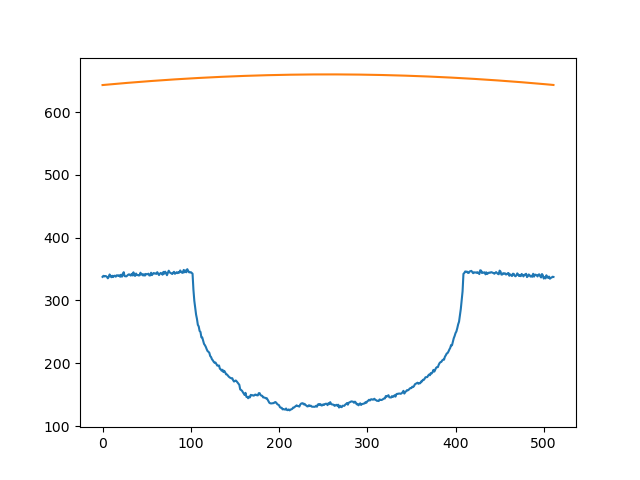

In [28]:
plt.figure()
plt.plot(np.mean(h,0))

dist = np.linspace(-256*0.0784 - 0.0392,256*0.0784 - 0.0392, 512)

factor = (152/(np.sqrt(dist**2 + 152**2)))**3

plt.plot(factor*660)

<IPython.core.display.Javascript object>


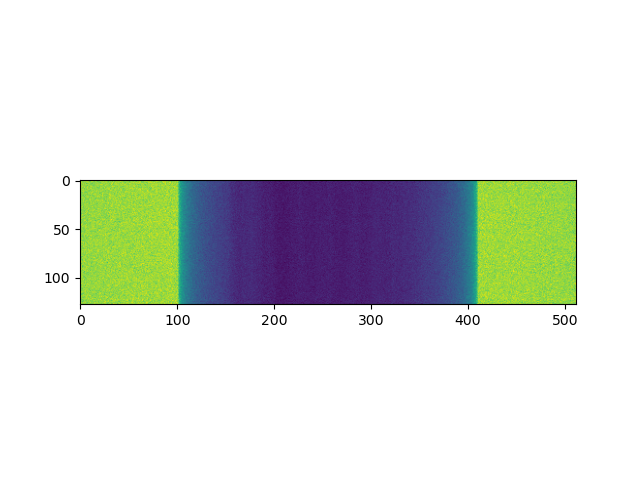

In [22]:
plt.figure()
plt.imshow(h)

In [29]:
np.save('w_spec6_profile_water_2',np.mean(h,0))

In [31]:
!cp w_spec6_profile_water_2.npy /home/xcite/fastCAT/tests/

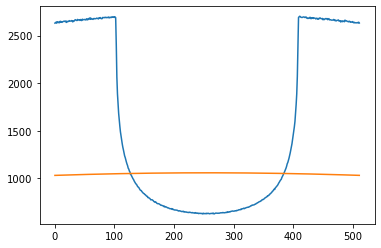

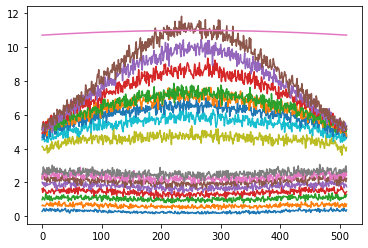

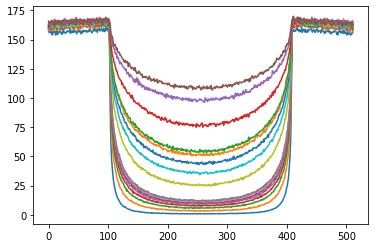

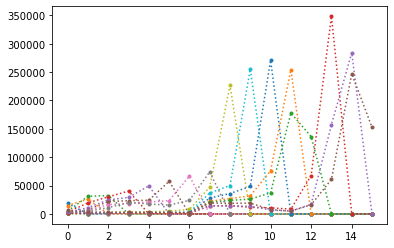

In [51]:
plt.figure()
plt.plot(np.array(total_slices),0.T)

dist = np.linspace(-256*0.0784 - 0.0392,256*0.0784 - 0.0392, 512)

factor = (152/(np.sqrt(dist**2 + 152**2)))**3

plt.plot(factor*1057)

plt.figure()
plt.plot(np.array(scatter_slices).T)
plt.plot(factor*11)

plt.figure()
plt.plot(np.array(prim_slices).T)

plt.figure()
plt.plot(np.array(speks).T,'.:');

In [109]:
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit as cf

dist = np.linspace(-256*0.0784 - 0.0392,256*0.0784 - 0.0392, 512)
factor = (152/(np.sqrt(dist**2 + 152**2)))**3

def func(x, a, b):

    return ((-(152/(np.sqrt(x**2 + 152**2)))**a)*b)

popt, pcov = cf(func, dist, h_prim)
                       
plt.figure()
plt.plot(dist,h_prim)
plt.plot(dist,func(dist, *popt))

plt.figure()

for ii in range(len(bin_edges_mod) - 1):
    
    y5 = np.logical_and(y['Energy [MeV]'] > bin_edges_mod[ii],y['Energy [MeV]'] < bin_edges_mod[ii+1]-0.0005)
    
    h_prim,xs = np.histogram(y['Position Y [cm]'][y5], bins = yedges)

    plt.plot(dist,h_prim,label = f'{bin_edges[ii]}-{bin_edges[ii+1]} MeV')
    
    popt, pcov = cf(func, dist, h_prim)
                       
#     plt.figure()
#     plt.plot(dist,h_prim)
    plt.plot(dist,func(dist, *popt))
    
plt.legend()
# plt.plot(factor**100*550)

ValueError: object too deep for desired array

error: Result from function call is not a proper array of floats.

In [77]:
#fit these curves

In [71]:
np.save('total',np.array(total_slices).T)
np.save('scatter',np.array(scatter_slices).T)
np.save('primary',np.array(prim_slices).T)
np.save('e_dist',np.array(speks).T);

In [154]:
np.array(total_slices).T.shape

(512, 16)

In [188]:
!cp total.npy scatter.npy primary.npy e_dist.npy ../../fastCAT/xpecgen/data/scatter/

In [155]:
!cp total_flood.npy scatter_flood.npy primary_flood.npy e_dist_flood.npy ../../fastCAT/tests/

<IPython.core.display.Javascript object>


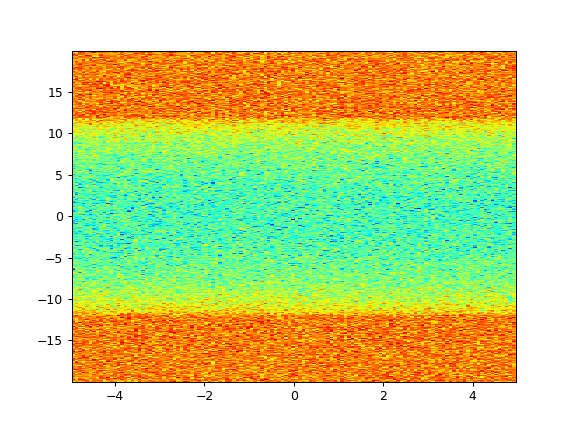

<IPython.core.display.Javascript object>


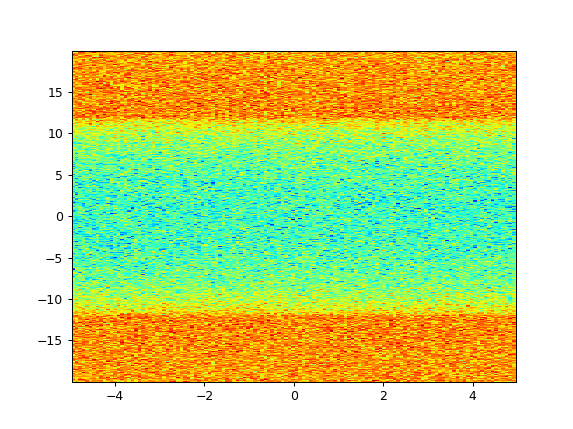

<IPython.core.display.Javascript object>


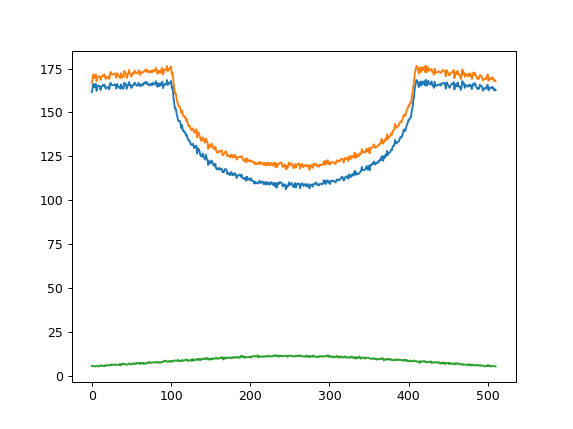

In [58]:
plt.figure()
h,xs,yx,ima = plt.hist2d(y['Position X [cm]'][y1],y['Position Y [cm]'][y1], bins = [xedges,yedges], cmap=cm.jet, norm=LogNorm());

# plt.figure()
# plt.plot(np.mean(h,0))

plt.figure()
h2,xs,yx,ima = plt.hist2d(y['Position X [cm]'],y['Position Y [cm]'], bins = [xedges,yedges], cmap=cm.jet, norm=LogNorm());

plt.figure()
plt.plot(np.mean(h,0))
plt.plot(np.mean(h2,0))
plt.plot(np.mean(h2,0) -np.mean(h,0))


In [12]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [16]:
y4 = y['Energy [MeV]'] < 5.995

<IPython.core.display.Javascript object>


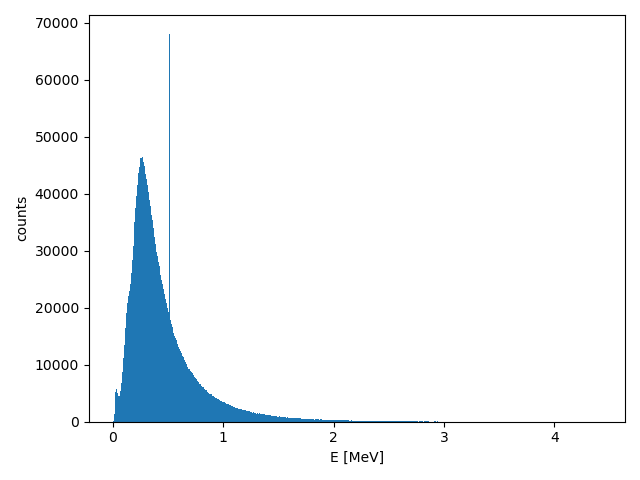

In [66]:
plt.figure()
plt.hist(y['Energy [MeV]'],bins=1000)
# plt.plot(s.x,s.y)
plt.xlabel('E [MeV]')
plt.ylabel('counts')
plt.tight_layout()

In [9]:
y4 = np.logical_and(y['Energy [MeV]'] < 0.5115, y['Energy [MeV]'] > 0.5105)

<IPython.core.display.Javascript object>


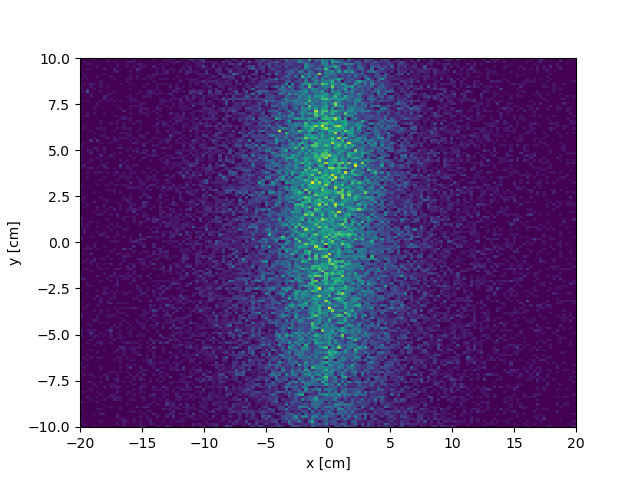

Text(0, 0.5, 'y [cm]')

In [10]:
plt.figure()
plt.hist2d(y['Position X [cm]'][y4],y['Position Z [cm]'][y4],bins=150);
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')

<IPython.core.display.Javascript object>


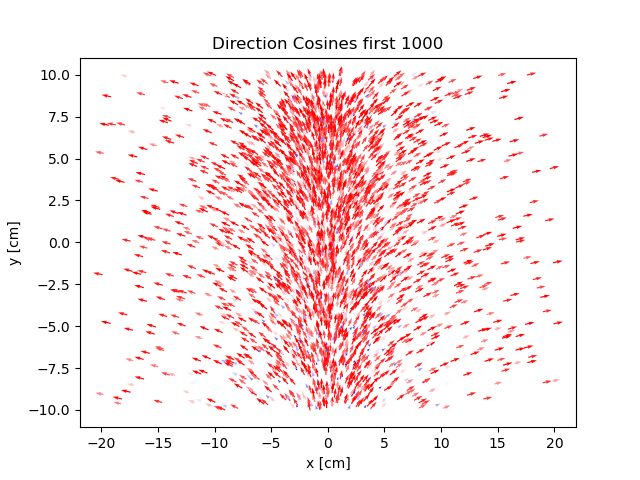

Text(0.5, 1.0, 'Direction Cosines first 1000')

In [73]:
plt.figure()
nn = 3000
color = np.sqrt((y['Direction Cosine X'][y4])**2 + (y['Direction Cosine Y'][y4])**2)
plt.quiver(y['Position X [cm]'][y4][:nn],y['Position Z [cm]'][y4][:nn],y['Direction Cosine X'][y4][:nn],y['Direction Cosine Y'][y4][:nn],color[:nn],scale = 50,cmap='bwr')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.title('Direction Cosines first 1000')

In [12]:
np.save('511_photons',y[y4])

In [13]:
y = np.load('511_photons.npy')

<IPython.core.display.Javascript object>


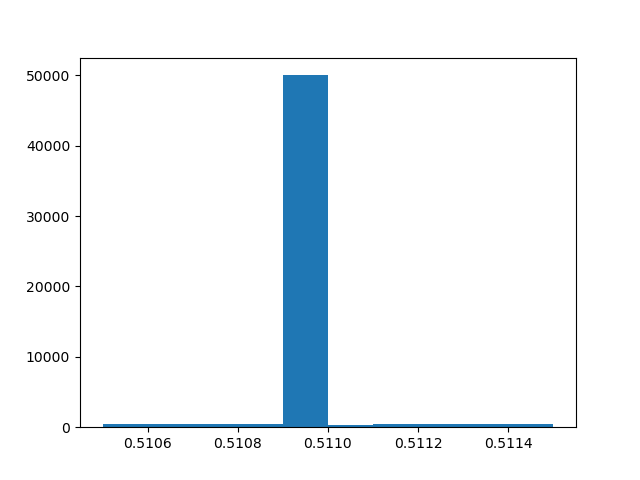

(array([  427.,   424.,   441.,   404., 50028.,   355.,   413.,   427.,
          445.,   403.]),
 array([0.51050013, 0.5106001 , 0.51070005, 0.51080006, 0.5109    ,
        0.511     , 0.51109993, 0.5111999 , 0.5112999 , 0.51139987,
        0.5114998 ], dtype=float32),
 <BarContainer object of 10 artists>)

In [14]:
plt.figure()
plt.hist(y['Energy [MeV]'])

<IPython.core.display.Javascript object>


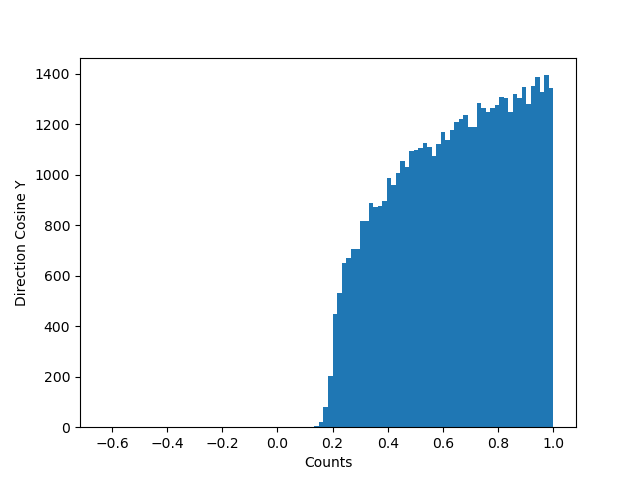

Text(0, 0.5, 'Direction Cosine Y')

In [81]:
plt.figure()
plt.hist(y['Direction Cosine Y'][y4],bins=100)
plt.xlabel('Counts')
plt.ylabel('Direction Cosine Y')

In [69]:
y['Flag to tell if Third Direction Cosine is Negative (1 means true)'][y4]

array([False,  True,  True, ..., False, False,  True])

<IPython.core.display.Javascript object>


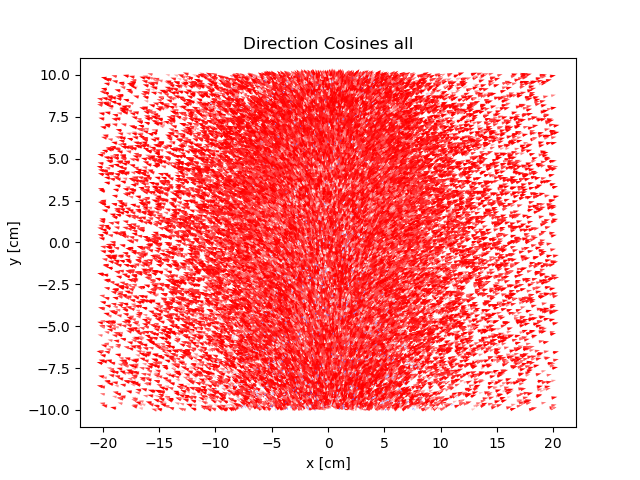

Text(0.5, 1.0, 'Direction Cosines all')

In [82]:
plt.figure()
n = -1
color = np.sqrt((y['Direction Cosine X'][y4])**2 + (y['Direction Cosine Y'][y4])**2)
plt.quiver(y['Position X [cm]'][y4],y['Position Z [cm]'][y4],y['Direction Cosine X'][y4],y['Direction Cosine Y'][y4],color,scale=80,cmap='bwr')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.title('Direction Cosines all')

<IPython.core.display.Javascript object>


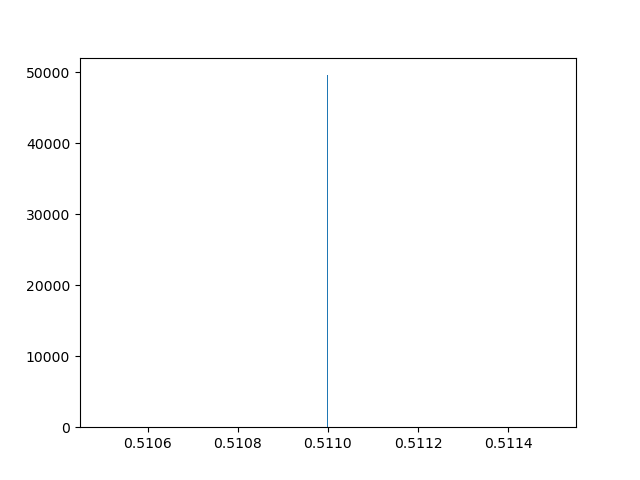

(array([3.0000e+00, 5.0000e+00, 5.0000e+00, 5.0000e+00, 5.0000e+00,
        1.0000e+00, 9.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00,
        2.0000e+00, 6.0000e+00, 4.0000e+00, 6.0000e+00, 1.0000e+00,
        4.0000e+00, 3.0000e+00, 4.0000e+00, 7.0000e+00, 6.0000e+00,
        4.0000e+00, 3.0000e+00, 8.0000e+00, 1.0000e+00, 2.0000e+00,
        3.0000e+00, 3.0000e+00, 5.0000e+00, 5.0000e+00, 4.0000e+00,
        7.0000e+00, 5.0000e+00, 4.0000e+00, 5.0000e+00, 8.0000e+00,
        2.0000e+00, 8.0000e+00, 4.0000e+00, 5.0000e+00, 4.0000e+00,
        5.0000e+00, 4.0000e+00, 4.0000e+00, 6.0000e+00, 7.0000e+00,
        8.0000e+00, 3.0000e+00, 6.0000e+00, 3.0000e+00, 6.0000e+00,
        5.0000e+00, 3.0000e+00, 6.0000e+00, 3.0000e+00, 8.0000e+00,
        4.0000e+00, 3.0000e+00, 1.0000e+00, 6.0000e+00, 3.0000e+00,
        2.0000e+00, 5.0000e+00, 3.0000e+00, 3.0000e+00, 4.0000e+00,
        9.0000e+00, 5.0000e+00, 4.0000e+00, 5.0000e+00, 4.0000e+00,
        4.0000e+00, 2.0000e+00, 4.0000e+00, 3.00

In [85]:
plt.figure()
plt.hist(y['Energy [MeV]'][y4],1000)

In [1]:
import sys

In [2]:
sys.path.insert(0,'/home/xcite/fastCAT/xpecgen')

In [7]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


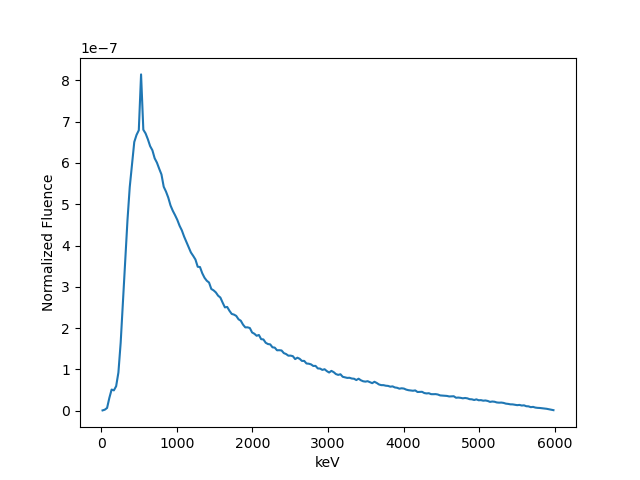

Text(0, 0.5, 'Normalized Fluence')

In [9]:
import xpecgen as xg
spectrum_files = ['Al_spectrum_25', 'C_spectrum_6', 'Al_spectrum_6', 'C_spectrum_25', 'W_spectrum_6', 'W_spectrum_25']

s = xg.Spectrum()
s.load(spectrum_files[-2])

plt.figure()
plt.plot(s.x,s.y)
plt.xlabel('keV')
plt.ylabel('Normalized Fluence')

In [37]:
sys.path

['../xpecgen',
 '../xpecgen',
 '/home/xcite/scintillators/noise',
 '/home/xcite/anaconda3/lib/python37.zip',
 '/home/xcite/anaconda3/lib/python3.7',
 '/home/xcite/anaconda3/lib/python3.7/lib-dynload',
 '',
 '/home/xcite/.local/lib/python3.7/site-packages',
 '/home/xcite/.local/lib/python3.7/site-packages/pytigre-0.1.8-py3.7-linux-x86_64.egg',
 '/home/xcite/.local/lib/python3.7/site-packages/pylinac-2.3.2-py3.7.egg',
 '/home/xcite/.local/lib/python3.7/site-packages/xpecgen-1.3.0-py3.7.egg',
 '/home/xcite/anaconda3/lib/python3.7/site-packages',
 '/home/xcite/anaconda3/lib/python3.7/site-packages/smop-0.41b0-py3.7.egg',
 '/home/xcite/anaconda3/lib/python3.7/site-packages/IPython/extensions',
 '/home/xcite/.ipython']

In [ ]:
plt.

<IPython.core.display.Javascript object>


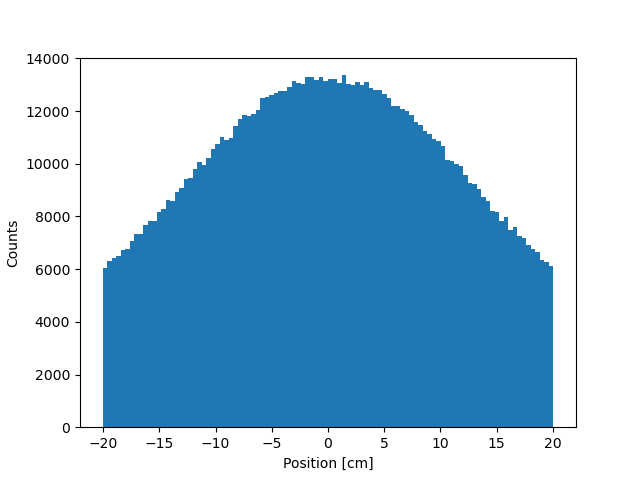

Text(0, 0.5, 'Counts')

In [20]:
plt.figure()
plt.hist(y['Position Y [cm]'][y4], bins = 100)
plt.xlabel('Position [cm]')
plt.ylabel('Counts')
# plt.plot(np.mean(h_prim,0))
 #,range=[5.99,6.001]);


In [ ]:
plt.figure()
plt.plot(np.mean())

<IPython.core.display.Javascript object>


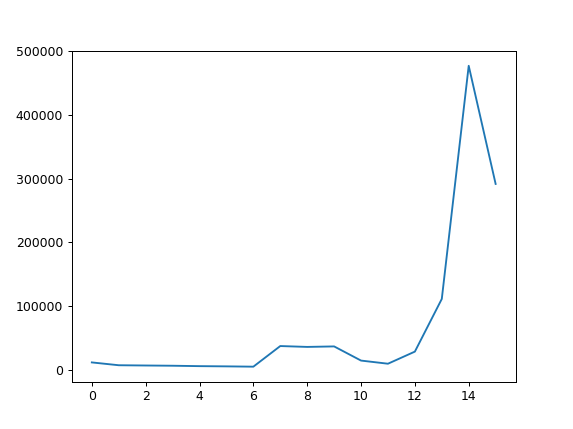

In [104]:
plt.figure()
plt.plot(speks[-1])

<IPython.core.display.Javascript object>


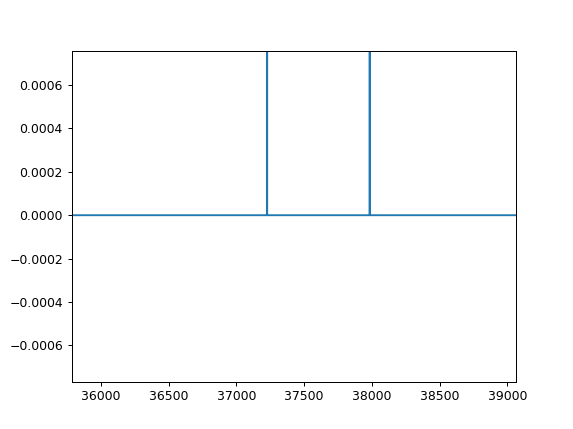

In [9]:
plt.figure()
plt.plot(y['Parent ID'])

In [8]:
y

array([(-0.94335115,  -4.201489 , -49.25, -0.00636613, -0.02781609, 0.10000104, 1., 22,  True,  True, 0),
       (-3.5655282 ,  18.112814 , -49.25, -0.02416137,  0.12004802, 0.10000134, 1., 22,  True,  True, 0),
       ( 4.6425433 ,  16.253872 , -49.25,  0.03108973,  0.10833021, 0.09999935, 1., 22,  True,  True, 0),
       ...,
       ( 3.9256694 ,  15.336057 , -49.25,  0.02658983,  0.10197674, 0.09999999, 1., 22,  True,  True, 0),
       ( 3.2730637 , -14.73152  , -49.25,  0.02180566, -0.09826804, 0.10000044, 1., 22,  True,  True, 0),
       (-1.2880086 ,  -3.1072888, -49.25,  0.10309327, -0.19905594, 0.09895995, 1., 22,  True,  True, 0)],
      dtype=[('Position X [cm]', '<f4'), ('Position Y [cm]', '<f4'), ('Position Z [cm]', '<f4'), ('Direction Cosine X', '<f4'), ('Direction Cosine Y', '<f4'), ('Energy [MeV]', '<f4'), ('Weight', '<f4'), ('Particle Type (in PDG Format)', '<i4'), ('Flag to tell if Third Direction Cosine is Negative (1 means true)', '?'), ('Flag to tell if this is the 

In [25]:
0.0782*64256

5.0048

<IPython.core.display.Javascript object>


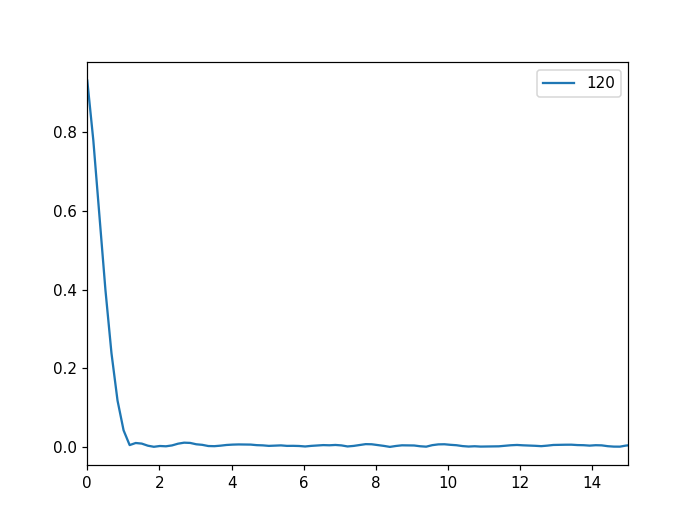

(0.0, 15.0)

In [24]:
# mtf = np.absolute(np.fft.fft(np.convolve(lsf,[0.2]*5)))
# mtf_final = np.fft.fftshift(mtf)

# N = len(mtf)

# T = 0.01

# xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

# mm = np.argmax(mtf_final)
# plt.figure()
# plt.plot(mtf_final[mm:]/mtf_final[mm])

mtf = np.absolute(np.fft.fft(lsf))
mtf_final = np.fft.fftshift(mtf)

N = len(mtf)

T = 0.02

xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

mm = np.argmax(mtf_final)

plt.figure()
plt.plot(xf,mtf_final[mm+1:]/mtf_final[mm])
plt.legend(['120','6000'])
plt.xlim([0,15])

# mtf = np.absolute(np.fft.fft(lsf2))
# mtf_final = np.fft.fftshift(mtf)

# N = len(mtf)

# T = 0.0336

# xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

# mm = np.argmax(mtf_final)

# # plt.figure()
# plt.plot(xf,mtf_final[mm+1:]/mtf_final[mm])
# plt.legend(['120','6000'])
# plt.xlim([0,15])

In [49]:
len(xf[:mm+1])

150

In [51]:
len(xf)

150

<IPython.core.display.Javascript object>


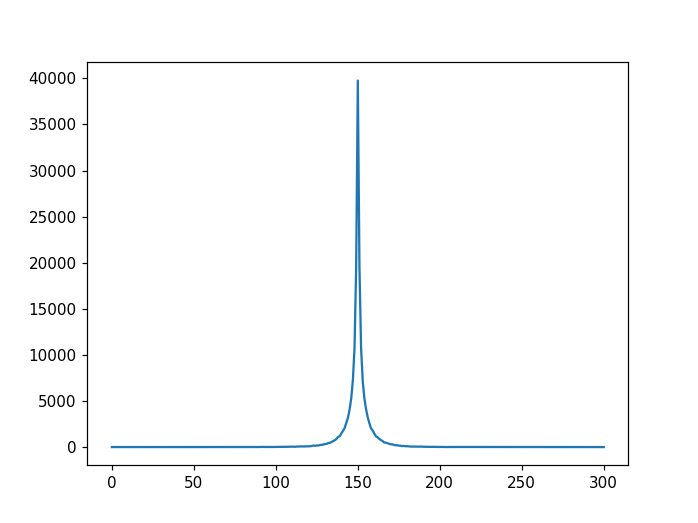

In [67]:
plt.figure()
plt.plot(h[150,:])
# plt.plot(h[41,:])
# plt.plot(h[42,:])

In [ ]:
from PIL import Image
import glob

# Create the frames
frames = []
imgs = sorted(glob.glob("analysis/2020-06-03-h14m33/*.png"))

for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save('png_to_gif.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

In [10]:
!cat ~/anaconda3/lib/python3.7/site-packages/topas2numpy/ntuple.py

# -*- coding: utf-8 -*-

# system imports
import re
import os.path

# third-party imports
import numpy as np

re_uint = '\d+'
re_str = '[\S+ \t]+'

binary_old_int_columns = [
    'Particle Type (in PDG Format)',
    'Run ID',
    'Event ID',
    'Track ID',
    'Parent ID',
    'Seed Part 1',
    'Seed Part 2',
    'Seed Part 3',
    'Seed Part 4',
]

limited_col_names = [
    ('Particle Type (sign from z direction)', np.int8),
    ('Energy (MeV) (-ve if new history)', 'f'),
    ('Position X (cm)', 'f'),
    ('Position Y (cm)', 'f'),
    ('Position Z (cm)', 'f'),
    ('Direction Cosine X', 'f'),
    ('Direction Cosine Y', 'f'),
    ('Weight', 'f'),
]


def read_ntuple(filepath):
    root, ext = os.path.splitext(filepath)
    ntuple_path = root + '.phsp'
    header_path = root + '.header'

    file_format, col_names = _sniff_format(header_path)

    if file_format == 'ascii':
        # preserve column names => cannot be viewed as a np.recarray
        # http://docs.scipy.org/doc/numpy-1

In [11]:
file

'PhotodiodeSurface_keV_6000.phsp'

In [12]:
!pwd

/home/xcite/topas/scintillators/Cu-GOS/runs


In [13]:
68372568/2848857

24.0

In [14]:
150398688/6266612

24.0

In [15]:
7437024/24

309876.0

In [36]:
xedges = np.linspace(-1.5876+0.0196,1.5876-0.0196,41)

(max(xedges) - min(xedges))/40

0.0784

In [34]:
0.25*0.784

0.196